### <b>reproduce FLH retrieval for OCI</b>
To test whether Rrs spectra have different fingerprint for pixels with high and low nFLH

In [1]:
import numpy as np
import xarray as xr
# import dask.array as da
# from dask.distributed import Client, LocalCluster

import earthaccess
from functools import partial
import statsmodels.api as sm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

auth = earthaccess.login()

In [2]:
# select a granule for testing
num_of_chunks = 10
granule = earthaccess.open(
    granules = ["https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250501T183011.L1B.V3.nc"]
)

# L2 data
granule = earthaccess.open(
    granules = ["https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250501T183011.L2.OC_AOP.V3_1.nc"]
)
# name2 = "/home/zhe2/data/PACE/L2_AOP/PACE_OCI.20250130T204559.L2.OC_AOP.V3_0.nc"
datatree2 = xr.open_datatree(granule[0])
ds2 = xr.merge(datatree2.to_dict().values())
ds2

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 3GB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 172, number_of_lines: 1710,
                    pixels_per_line: 1272)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 1kB 346.0 348.0 351.0 ... 717.0 719.0
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/32)
    wavelength     (number_of_bands) float64 2kB ...
    vcal_gain      (number_of_reflective_bands) float32 1kB ...
    vcal_offset    (number_of_reflective_bands) float32 1kB ...
    F0             (number_of_reflective_bands) float32 1kB ...
    aw             (number_of_reflective_bands) float32 1kB ...
    bbw            (number_of_reflective_bands) float32 1kB ...
    ...             ...
    avw            (number_of_lines, pixels_per_line) float32 9MB ...
    nflh           (number_of_lines, pixels_per_line) float32 9MB ...
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB ...
    longitude      (number_of_lines, pixels_per_line) float32 9MB ...
    latitude       (number_of_lines, pixels_per_line) float32 9MB ...
    tilt           (number_of_lines) float32 7kB ...
Attributes: (12/47)
    title:                             OCI Level-2 Data AOP
    product_name:                      PACE_OCI.20250501T183011.L2.OC_AOP.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data1/sdpsoper/vdc/vpu20/wo...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                -105.20019
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9847794771194458
    geospatial_bounds:                 POLYGON ((-74.89859 41.61203, -105.200...

In [3]:
# subset ds2 to: 1) select some variables; 2) align wavelength range!
wavelength_3d = ds2.wavelength_3d.values
wavelength    = ds2.wavelength.values
index         = np.isin(wavelength, wavelength_3d)
ds2_sub       = ds2.isel(number_of_bands=index, number_of_reflective_bands=index)

# squeeze
ds2_sub = ds2_sub.rename({'number_of_bands': 'wavelength_3d', 
                'number_of_reflective_bands': 'wavelength_3d'
                }).squeeze()

print("squeezed!")

squeezed!


### <b>Choose low-nFLH pixels as baseline & high-nFLH for comparison?</b>

In [ ]:
# Create 2D boolean mask
mask1 = ds2_sub['nflh'].values < 0.01
# Get indices where condition is True
indices1 = np.where(mask1)

In [5]:
# Select using both dimension indices
dim1, dim2 = ds2_sub['nflh'].dims
low_nFLH = ds2_sub.isel({dim1: indices1[0], dim2: indices1[1]})

In [6]:
# Mask values but keep dimensions (faster than drop=True)
high_nFLH = ds2_sub.where(ds2_sub['nflh'] >= .5)

In [34]:
mask2 = ds2_sub['nflh'].values >= 0.3
high_nFLH_mat = ds2_sub.Rrs.values[mask2, :]

In [31]:
mask1 = (ds2_sub['nflh'].values > 0.1) & (ds2_sub['nflh'].values < 0.2)
low_nFLH_mat = ds2_sub.Rrs.values[mask1, :]

### <b>Take average?</b>

In [32]:
high_nFLH_avg = high_nFLH_mat.mean(axis=0)
low_nFLH_avg  = low_nFLH_mat.mean(axis=0)

Text(0, 0.5, 'Rrs [1/sr]')

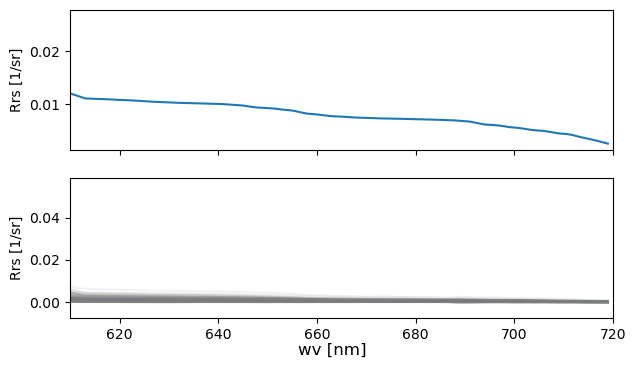

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(7,4), sharex=True)
ax[0].plot(wavelength_3d, high_nFLH_avg)
ax[0].plot(wavelength_3d, high_nFLH_mat)
ax[1].plot(wavelength_3d, low_nFLH_avg)
ax[1].plot(wavelength_3d, low_nFLH_mat[::100,].transpose(), color='gray', alpha=0.1)
ax[1].set_xlim(610, 720)
fig.supxlabel("wv [nm]")
ax[0].set_ylabel("Rrs [1/sr]")
ax[1].set_ylabel("Rrs [1/sr]")
# fig.suptitle(f"select: number_of_lines={lines}, px_per_line={px}")

Text(0.5, 0.98, 'select: number_of_lines=28, px_per_line=896')

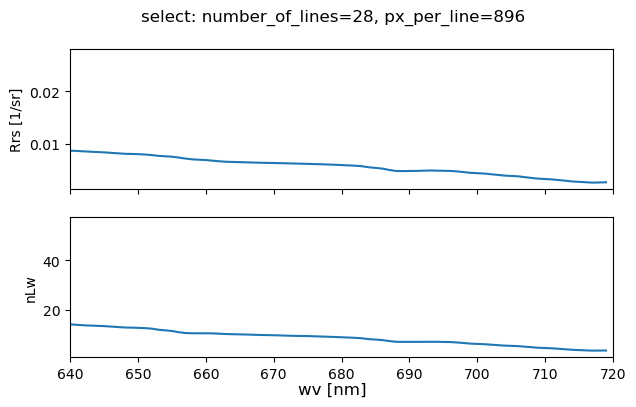

In [72]:
# vis.
lines = 28
px    = 896
Rrs_sp = ds2_chunk.Rrs.isel(number_of_lines=lines, pixels_per_line=px)
nLw_sp = ds2_chunk.nLw.isel(number_of_lines=lines, pixels_per_line=px)
fig, ax = plt.subplots(2, 1, figsize=(7,4), sharex=True)
ax[0].plot(wavelength_3d, Rrs_sp)
ax[1].plot(wavelength_3d, nLw_sp)
ax[1].set_xlim(640, 720)
fig.supxlabel("wv [nm]")
ax[0].set_ylabel("Rrs [1/sr]")
ax[1].set_ylabel("nLw")
fig.suptitle(f"select: number_of_lines={lines}, px_per_line={px}")

In [73]:
def find_nearest(arr, trg):
    idx = [np.argmin(np.abs(arr - i)) for i in trg]
    return idx

def linear_fit(wavlen, ydata):
    # add constants & fit
    X = sm.add_constant(wavlen)
    mod = sm.OLS(ydata, X)
    res = mod.fit()
    # get fitting results
    c0, c1 = res.params
    cov00, cov01, _, cov11 = res.cov_params().flatten()
    return c0, c1, cov00, cov01, cov11

In [74]:
# baseline wavelengths
base_wv = np.array([649.599976, 650.900024, 652.099976, 653.299988,
                    654.599976, 655.799988, 657.099976, 658.299988,
                    659.599976, 710.500000, 711.799988, 713.000000,
                    714.299988, 716.799988, 719.200012])
# base_wv = np.array([649.599976, 650.900024, 652.099976, 653.299988,
#                     654.599976, 655.799988, 657.099976, 658.299988,
#                     659.599976, 710.500000, 711.799988, 713.000000,
#                     714.299988, 716.799988])
fluo_wv = 678.20001
# mask_bl = find_nearest(wavelength3d.values, base_wv)
mask_bl  = find_nearest(wavelength_3d, base_wv)
print(wavelength_3d[mask_bl])
y_sample = nLw_sp.values

[650. 651. 652. 653. 655. 656. 657. 658. 660. 711. 712. 713. 714. 717.
 719.]


In [75]:
c0, c1, _, _, _ = linear_fit(wavelength_3d[mask_bl], y_sample[mask_bl])
bl_sp   = c0 + c1 * wavelength_3d
mask_fl = find_nearest(wavelength_3d, [fluo_wv])
nflh_sp = y_sample[mask_fl] - bl_sp[mask_fl]
print(f"retrieved fluorescence line height = {nflh_sp} W/m2/µm/sr")

retrieved fluorescence line height = [0.56188836] W/m2/µm/sr


In [77]:
nflh_ref = ds2_chunk.nflh.sel(number_of_lines=lines, pixels_per_line=px).values
print(f"product fluorescence line height = {nflh_ref}")

product fluorescence line height = 0.5908850431442261


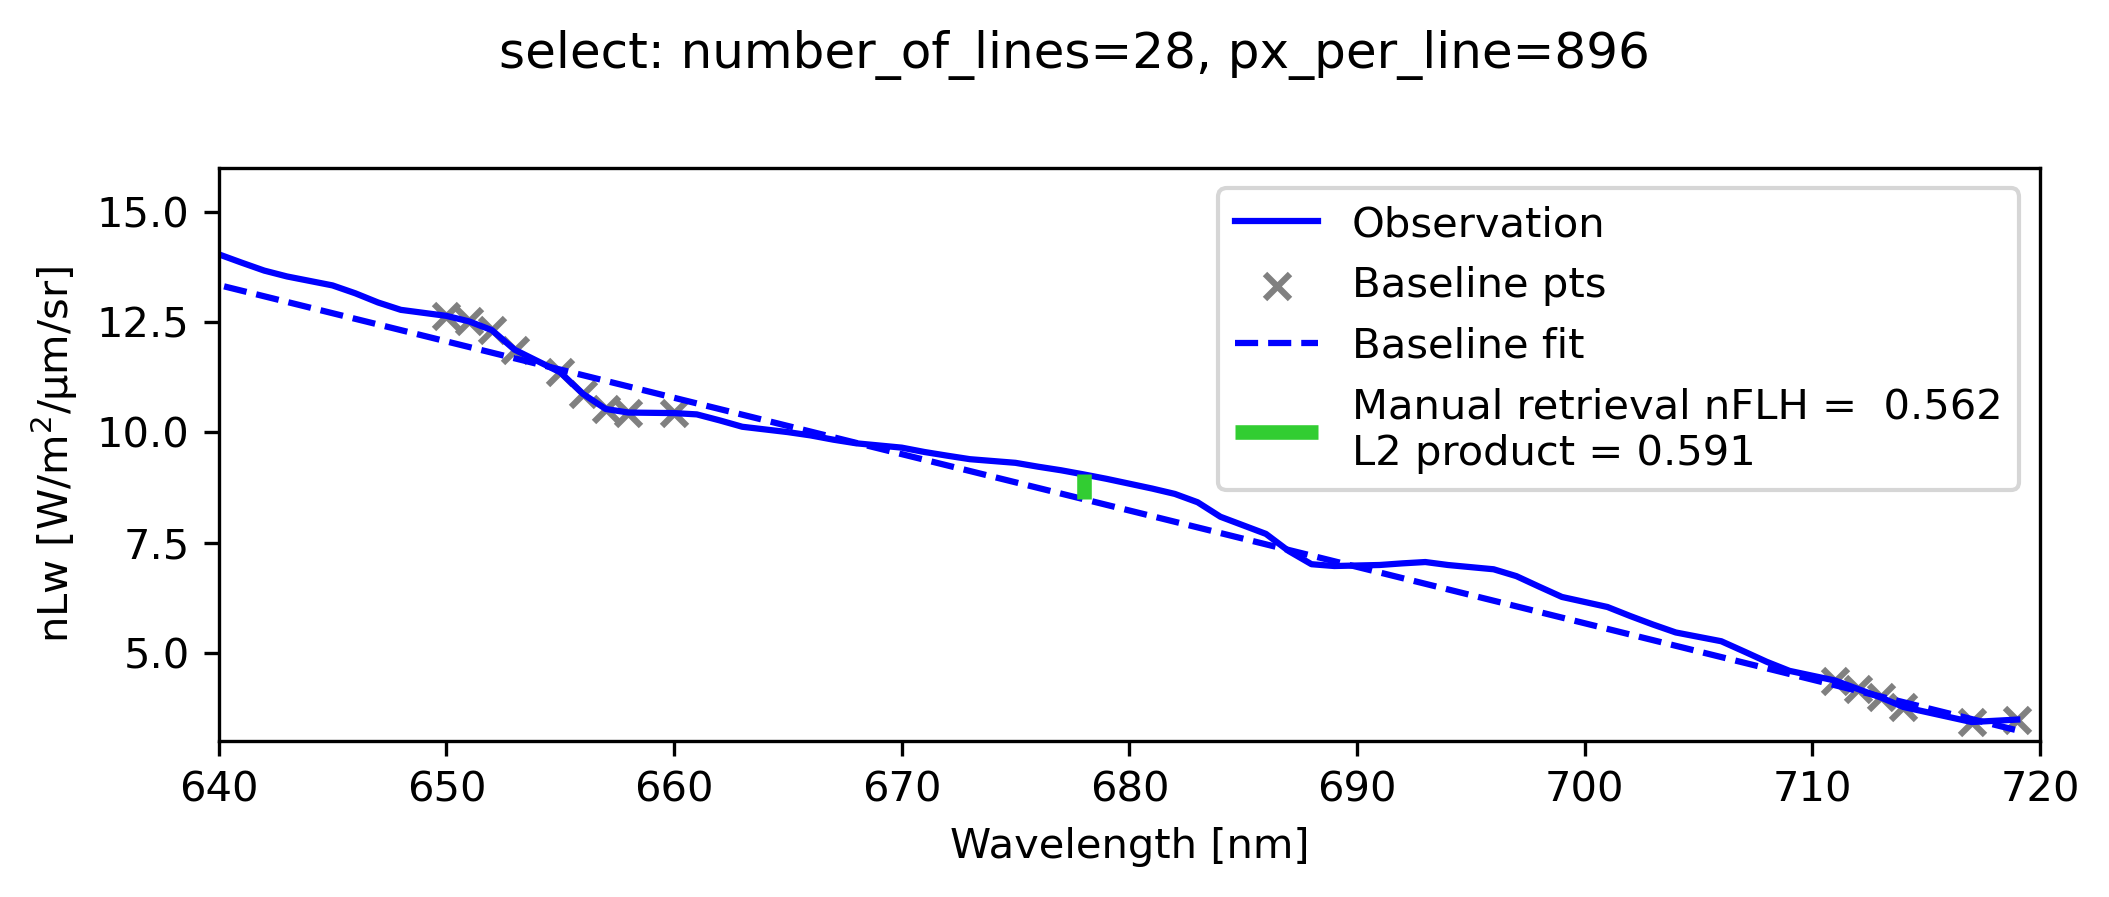

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,3), sharex=True,
                        layout="tight",
                        # dpi=300
                        )
ax.plot(wavelength_3d, y_sample, "b", label="Observation")
ax.scatter(wavelength_3d[mask_bl], y_sample[mask_bl], c="grey", marker="x", label="Baseline pts")
ax.plot(wavelength_3d, bl_sp, "b--", label="Baseline fit")
ax.vlines(wavelength_3d[mask_fl], bl_sp[mask_fl], y_sample[mask_fl],
          linewidth=3.5, color="limegreen",
          label=f"Manual retrieval nFLH = {nflh_sp[0]: .3f}\nL2 product = {nflh_ref:.3f}"
          )

ax.set_xlim(640, 720)
ax.set_ylim(3, 16)
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("nLw [W/m$^2$/µm/sr]")
ax.legend()
fig.suptitle(f"select: number_of_lines={lines}, px_per_line={px}")

# fig.savefig("Example_nFLH.png")

### <b>Apply to the whole scene</b>

In [14]:
from functools import partial

Text(0.5, 1.0, 'PACE_OCI.20250501T183011')

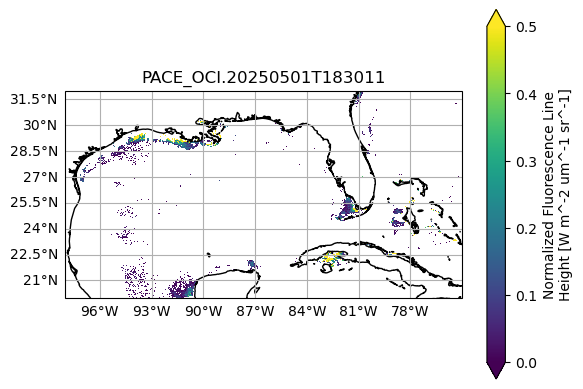

In [85]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = ds2_chunk["nflh"].plot(
    x="longitude", y="latitude", cmap="viridis", vmin=0, vmax=.5, ax=ax
)
ax.set_ylim(20, 32)
ax.set_xlim(-98, -75)
ax.set_title("PACE_OCI.20250501T183011")

# fig.savefig("Granule.png")

In [82]:
def nflh_oci(nLw_arr, mark, wv_arr, baseline_wv, fluo_wv):
    if not (mark==mark):
        return np.nan
    c0, c1, _, _, _ = linear_fit(wv_arr[baseline_wv], nLw_arr[baseline_wv])
    # baseline
    baseline_spec = c0 + c1 * wv_arr
    # line height
    fluo_line_height = nLw_arr[fluo_wv] - baseline_spec[fluo_wv]
    # return
    return fluo_line_height[0]


In [17]:
nflh_func = partial(nflh_oci, wv_arr=wavelength_3d, baseline_wv=np.array(mask_bl), fluo_wv=np.array(mask_fl))


In [19]:
result_lazy = xr.apply_ufunc(
    nflh_func,
    ds2_chunk.nLw,
    ds2_chunk.nflh,
    input_core_dims=[['wavelength_3d'],[]], # compute over wavelength_3d
    output_core_dims=[[]],    # the output contains no wavelength_3d dim
    # dask='parallelized',
    output_dtypes=[float],
    vectorize=True,
)


In [20]:
result_lazy

<xarray.DataArray (number_of_lines: 1710, pixels_per_line: 1272)> Size: 17MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(1710, 1272))
Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 9MB -98.3 ... -74.9
    latitude   (number_of_lines, pixels_per_line) float32 9MB 18.55 ... 41.61
Dimensions without coordinates: number_of_lines, pixels_per_line

Text(0.5, 1.0, 'retrieved nFLH')

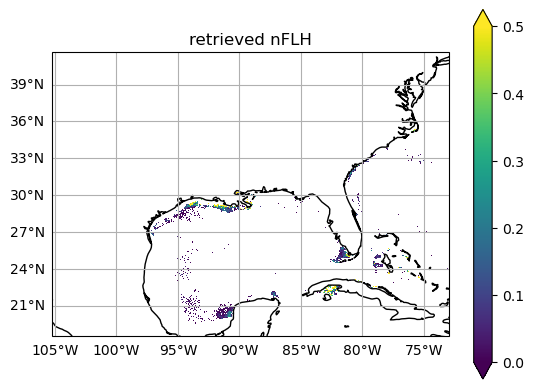

In [21]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
result_lazy.plot(
    x="longitude", y="latitude", cmap="viridis", vmin=0, vmax=.5, ax=ax
)
ax.set_title("retrieved nFLH")

### <b>Scatter plot</b>

In [23]:
from scipy.stats import gaussian_kde

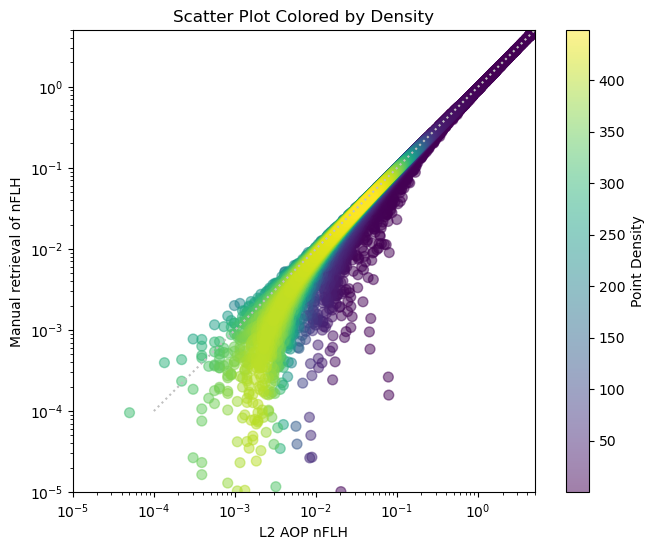

In [102]:
# 1. Generate some sample data
x = ds2_chunk["nflh"].values
y = result_lazy.values
ind = (x==x) & (y==y)
x = x[ind]
y = y[ind]

# 2. Calculate the point density
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# 3. Sort points by density to ensure the densest points are on top
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# 4. Create the scatter plot, using 'z' for coloring
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, c=z, s=50, cmap='viridis', alpha=.5)
ax.plot([1E-4, 10], [1E-4, 10], ":", color="silver")

# Customize the plot
min_val = 1E-5 # max(1E-5, x.min(), y.min())
max_val = 5 # min(1,    x.max(), y.max())
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
ax.set_title('Scatter Plot Colored by Density')
ax.set_xlabel('L2 AOP nFLH')
ax.set_ylabel('Manual retrieval of nFLH')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal', adjustable='box')
cbar = fig.colorbar(ax.collections[0])
cbar.set_label('Point Density')
plt.show()